Importing all the important llibraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px
import plotly.graph_objects as go

Downloading the database from the release section as follows: https://github.com/jknecht/baseball-archive-sqlite/releases/tag/2022


In [2]:
#Getting the data from the website via wget command
#Please change the basepath
file_path = 'C:\\UMD\\Sem 1\\MSML602 Principles in Data Science\\Assignment 3\\'
sqlite_file = f'{file_path}\\lahman_1871-2022.sqlite'

command = "wget https://github.com/jknecht/baseball-archive-sqlite/releases/download/2022/lahman_1871-2022.sqlite"
if not os.path.exists(sqlite_file): os.system(command)

#Testing the file whether its correct or not
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()
salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


In [3]:
#Displaying all the tables
display_query = 'SELECT name FROM sqlite_master WHERE type="table"'
data = cursor.execute(display_query)
for tables in data.fetchall():
    print(tables[0])

AllstarFull
Appearances
AwardsManagers
AwardsPlayers
AwardsShareManagers
AwardsSharePlayers
Batting
BattingPost
CollegePlaying
Fielding
FieldingOF
FieldingOFsplit
FieldingPost
HallOfFame
HomeGames
Managers
ManagersHalf
Parks
People
Pitching
PitchingPost
Salaries
Schools
SeriesPost
Teams
TeamsFranchises
TeamsHalf


#Part 1: Wrangling

In [4]:
#Visualizing the information about total payroll for each team per year
salary_query = """SELECT yearID, teamID, sum(salary) AS total_payroll
                FROM Salaries
                GROUP BY yearID, teamID"""
team_payroll_info = pd.read_sql(salary_query, conn)
team_payroll_info

,yearID,teamID,total_payroll
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0
...,...,...,...
913,2016,SLN,143053500.0
914,2016,TBA,57097310.0
915,2016,TEX,176038723.0
916,2016,TOR,138701700.0


In [5]:
#Visualizing the information about the win percentage for each team per year
win_percent_query = """SELECT
                    yearID, teamID, W, L, G, CG, W + L as total_games,
                    CAST(W AS FLOAT) / (CAST(W AS FLOAT) + CAST(L AS FLOAT)) * 100 as win_percentage
                    FROM TEAMS"""
win_percentage = pd.read_sql(win_percent_query, conn)
win_percentage

,yearID,teamID,W,L,G,CG,total_games,win_percentage
0,1871,BS1,20,10,31,22,30,66.666667
1,1871,CH1,19,9,28,25,28,67.857143
2,1871,CL1,10,19,29,23,29,34.482759
3,1871,FW1,7,12,19,19,19,36.842105
4,1871,NY2,16,17,33,32,33,48.484848
...,...,...,...,...,...,...,...,...
3010,2022,PIT,62,100,162,0,162,38.271605
3011,2022,SDN,89,73,162,0,162,54.938272
3012,2022,SFN,81,81,162,1,162,50.000000
3013,2022,SLN,93,69,162,3,162,57.407407


In [6]:
#Checking whether G == W + L or not
check_sql = """SELECT yearID, teamID, W, L, G
                FROM Teams
                WHERE G < W + L    """
check_games = pd.read_sql(check_sql, conn)
check_games

,yearID,teamID,W,L,G
0,1882,LS2,42,38,79
1,1882,SL4,37,43,79
2,1884,CNU,69,36,103
3,1884,WIL,2,16,17
4,1892,PIT,80,73,152
5,1897,CL4,69,62,130
6,1979,CHA,73,87,159
7,1979,DET,85,76,160


We can observe that there exists inconsistencies between number of games won, lost and total number of games. So, it is better to choose win + lose because there is no draw in baseball.

In [7]:
#Real SQL code
payroll_vs_wins = """SELECT * FROM
                    (SELECT yearID as salary_yearID, teamID as salary_teamID, sum(salary) AS total_payroll
                    FROM Salaries
                    GROUP BY yearID, teamID) AS Salary
                    JOIN
                    (SELECT
                    yearID as team_yearID, teamID as team_teamID, W, L, W + L as total_games,
                    CAST(W AS FLOAT) / (CAST(W AS FLOAT) + CAST(L AS FLOAT)) * 100 as win_percentage
                    FROM Teams) as Team
                    ON Salary.salary_yearID == Team.team_yearID
                    AND Salary.salary_teamID == Team.team_teamID;"""
payroll_win_data = pd.read_sql(payroll_vs_wins, conn)

#Verification
error_message = "There is some error such that the columns are not matching"
assert (len((payroll_win_data['salary_yearID'] == payroll_win_data['team_yearID']).unique())) == 1, error_message
assert (len((payroll_win_data['salary_teamID'] == payroll_win_data['team_teamID']).unique())) == 1, error_message

#Changes to data to make it look better in pandas
payroll_win_data['yearID'] = payroll_win_data['salary_yearID']
payroll_win_data['teamID'] = payroll_win_data['salary_teamID']
payroll_win_data.drop(columns=['salary_yearID', 'team_yearID', 'team_teamID', 'salary_teamID'], inplace=True)
payroll_win_data

,total_payroll,W,L,total_games,win_percentage,yearID,teamID
0,14807000.0,66,96,162,40.740741,1985,ATL
1,11560712.0,83,78,161,51.552795,1985,BAL
2,10897560.0,81,81,162,50.000000,1985,BOS
3,14427894.0,90,72,162,55.555556,1985,CAL
4,9846178.0,85,77,162,52.469136,1985,CHA
...,...,...,...,...,...,...,...
913,143053500.0,86,76,162,53.086420,2016,SLN
914,57097310.0,68,94,162,41.975309,2016,TBA
915,176038723.0,95,67,162,58.641975,2016,TEX
916,138701700.0,89,73,162,54.938272,2016,TOR


#Part 2: Exploratory Data Analysis
##Problem 2

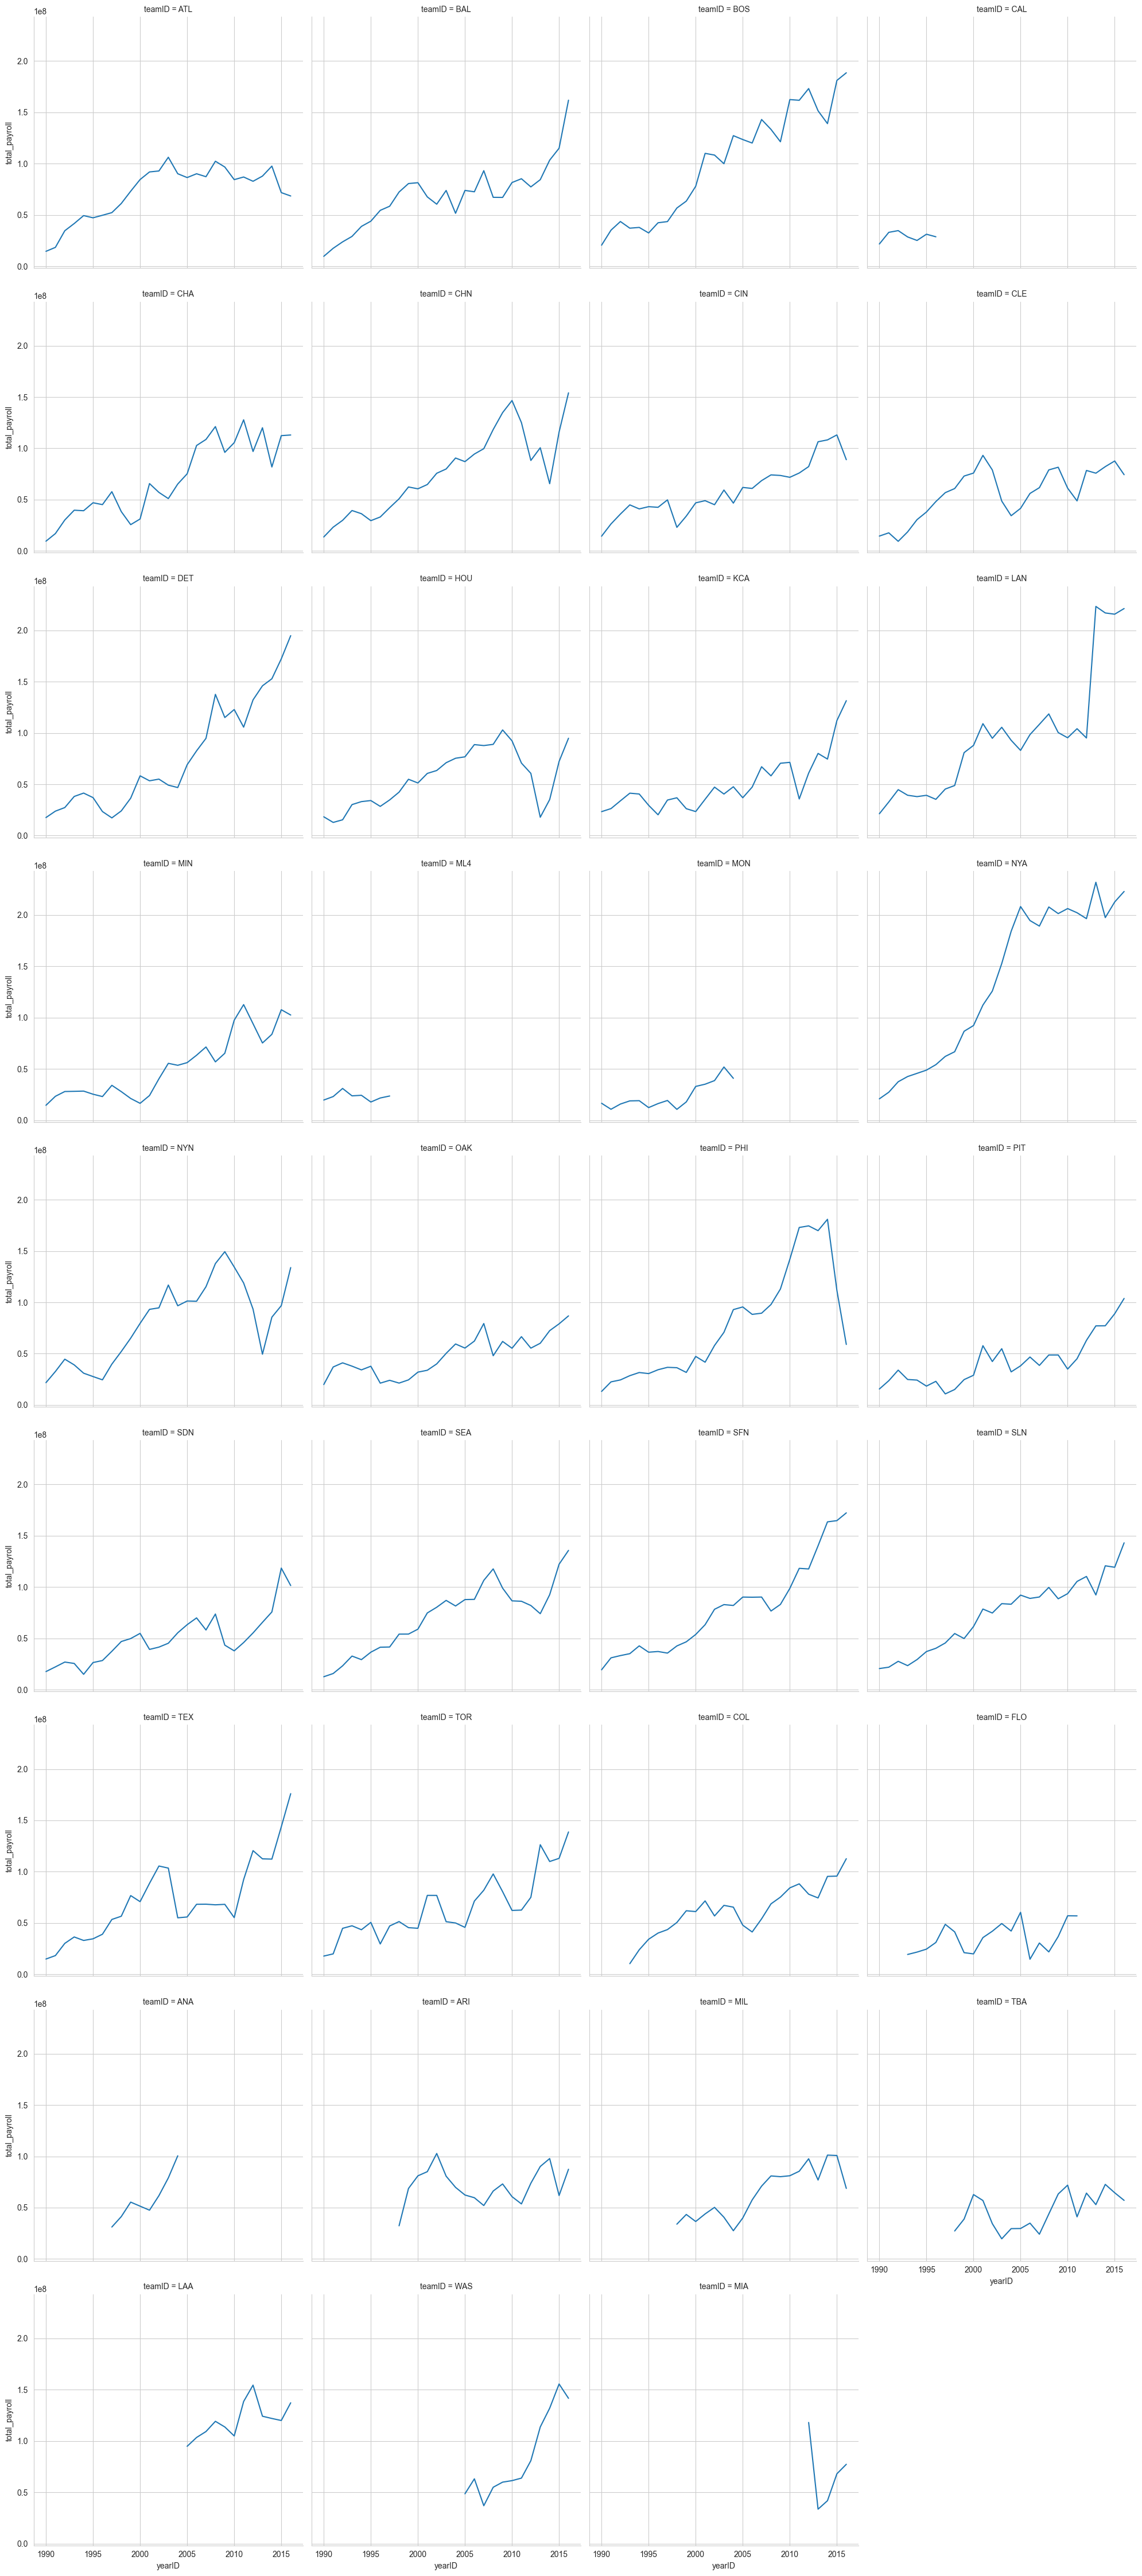

In [8]:
#Choosing all payroll info from the year 1990
salaries = team_payroll_info[team_payroll_info['yearID'] >= 1990]

#Plotting all teams data across years
sns.set_style("whitegrid")
ax = sns.relplot(data=salaries, x='yearID', y='total_payroll',
            col='teamID', col_wrap=4, kind='line')

##Question 1 and Problem 3
What statements can you make about the distribution of payrolls conditioned on time based on these plots?


---


Mean payrolls are increasing over time

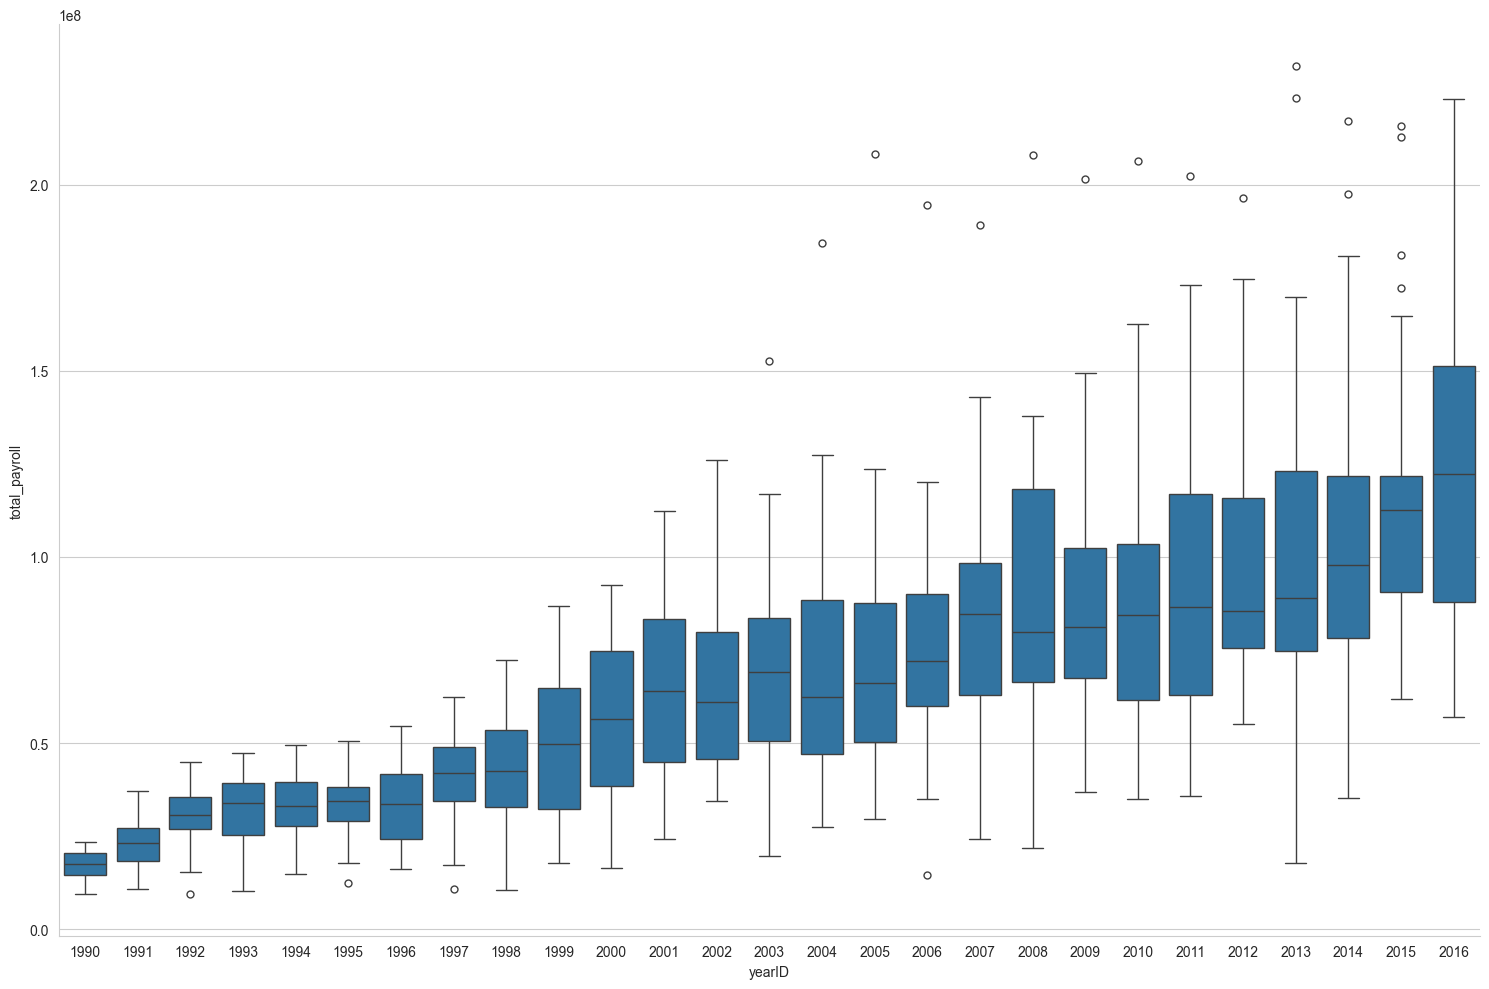

In [9]:
sns.catplot(data=salaries, x='yearID', y='total_payroll', estimator='mean', kind='box', height=10, aspect=1.5)

In [10]:
#Computing ranges. For that one needs to find minimum and maximum
range_salaries = salaries.groupby(by='yearID', as_index=False)['total_payroll'].agg({'min', 'max'})
range_salaries['range'] = range_salaries['max'] - range_salaries['min']

#Because of agg(), yearID becomes index. Need to resolve
range_salaries = range_salaries.reset_index()

px.line(data_frame=range_salaries, x='yearID', y='range', markers=True, title='Range of spending per year')

##Problem 4

In [11]:
#Selecting the data from years 1990 - 2016
payroll_win_data = copy.deepcopy(payroll_win_data[payroll_win_data['yearID'] >= 1990])

#Dividing payroll data into 5 year ranges
payroll_win_data['year_range'] = pd.cut(payroll_win_data['yearID'], 5)
mean_data = payroll_win_data.groupby(by=['year_range', 'teamID'], as_index=False)[['win_percentage', 'total_payroll']].mean()

C:\Users\peeyu\AppData\Local\Temp\ipykernel_13020\1118615396.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [12]:
#There are teams like ANA and ARI that do not exist in the years 1984 to 1991.
#So, removing these rows.
mean_data.dropna(inplace=True)
mean_data.rename(columns={"win_percentage": "mean_win_percentage", 'total_payroll': 'mean_payroll'}, inplace=True)
mean_data

,year_range,teamID,mean_win_percentage,mean_payroll
2,"(1989.974, 1995.2]",ATL,57.498105,3.430745e+07
3,"(1989.974, 1995.2]",BAL,50.254326,2.714476e+07
4,"(1989.974, 1995.2]",BOS,51.216005,3.446193e+07
5,"(1989.974, 1995.2]",CAL,47.052832,2.908284e+07
6,"(1989.974, 1995.2]",CHA,54.892294,3.040221e+07
...,...,...,...,...
170,"(2010.8, 2016.0]",SLN,56.687243,1.151638e+08
171,"(2010.8, 2016.0]",TBA,51.176500,5.874833e+07
172,"(2010.8, 2016.0]",TEX,54.469313,1.262282e+08
173,"(2010.8, 2016.0]",TOR,50.720165,1.042466e+08


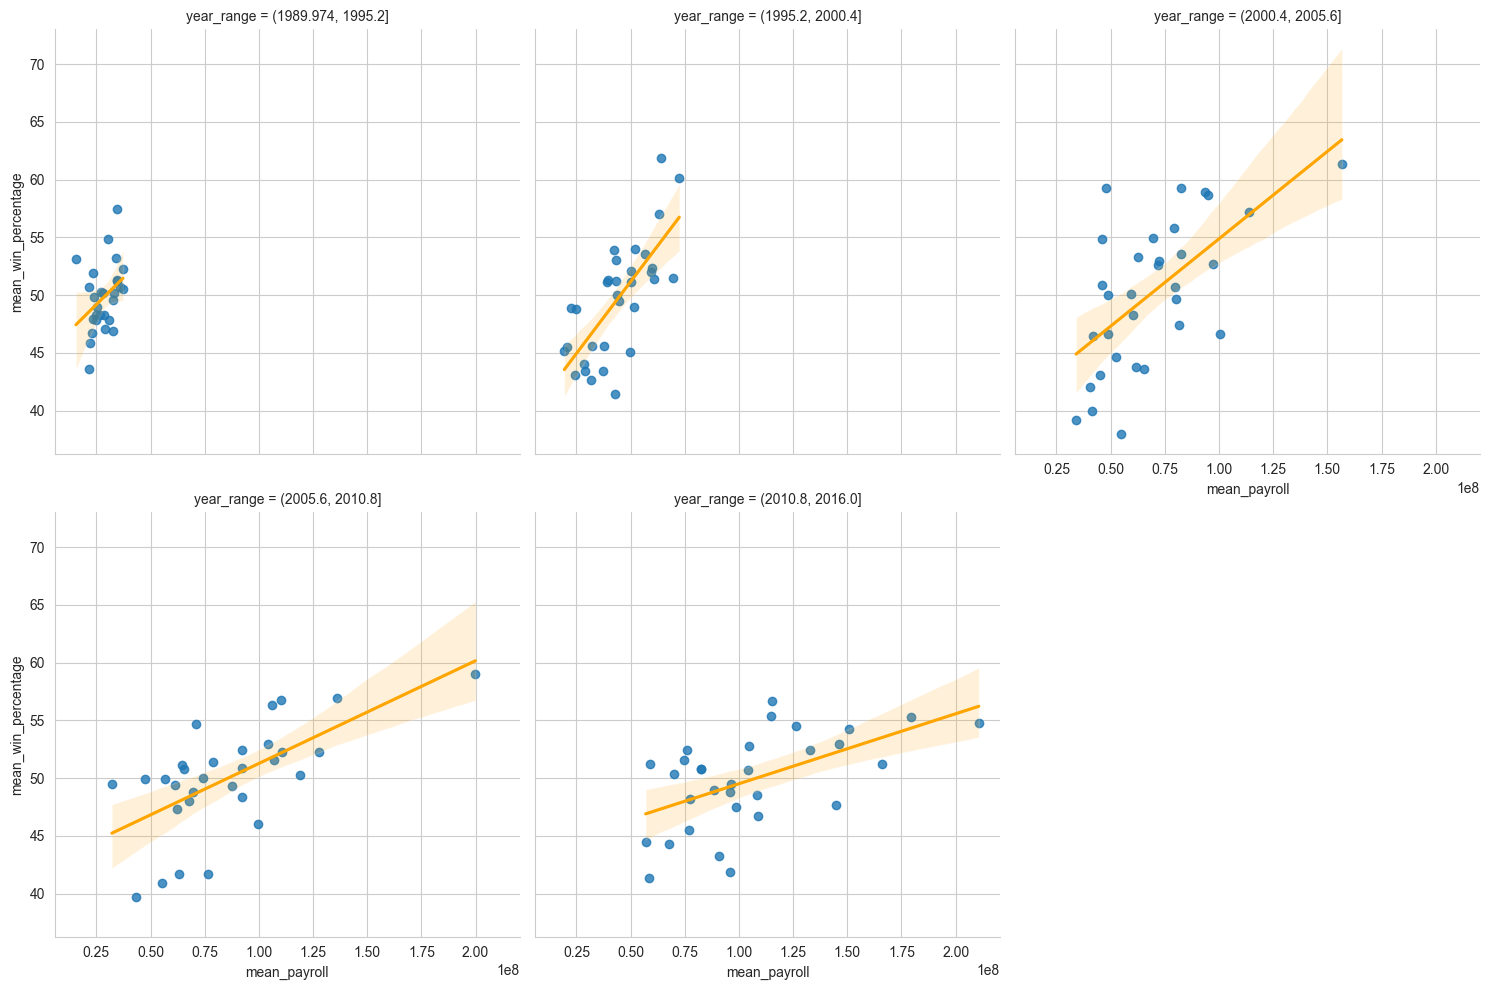

In [13]:
#Plotting with regression line
sns.lmplot(data=mean_data, x="mean_payroll", y="mean_win_percentage",
           col="year_range", col_wrap=3, line_kws={'color': 'orange'})

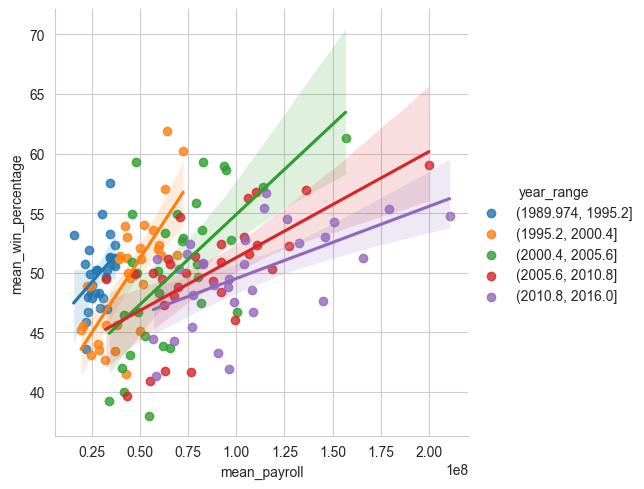

In [14]:
#Plotting just to visualize how the lines are
sns.lmplot(data=mean_data, x="mean_payroll", y="mean_win_percentage",
           hue="year_range")

##Question 2
What can you say about team payrolls across these periods?


---


We can observe that the slope between the team payrolls and win percentage is decreasing.

Are there any teams that standout as being particularly good at paying for wins across these time periods?

---
Team NYA, which has been one of the costliest teams, has most of the time highest winning probability.



What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

---
By looking at the plot below, Oakland's spending efficiency in the years 2001 to 2005 is the best. They were outclassed by only 1 team (NYA) in terms of mean win percentage (only by atmost 3%) in these years but their mean payroll is the lowest.

 This can be observed from the graph below. The higher the winner percentage, the better. The lower the mean payroll, the better. This means that the point on the top-left of the graph will be better.  


In [15]:
px.scatter(mean_data, x='mean_payroll', y='mean_win_percentage', color='teamID',
            facet_col='year_range', facet_col_wrap=3)

c:\UMD\Sem 1\MSML602 Principles in Data Science\.venv\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [16]:
oak_mean_data = mean_data[mean_data['teamID'] == 'OAK']
px.scatter(oak_mean_data, x='mean_payroll', y='mean_win_percentage',
            facet_col='year_range', facet_col_wrap=3)

c:\UMD\Sem 1\MSML602 Principles in Data Science\.venv\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##Problem 5
$$standardized\_payroll_{ij} = \frac{payroll_{ij} - avg\_payroll_j}{s_j}$$
for team $i$ in year $j$.

In [17]:
#Finding the mean and standard deviation of payroll per year
yearly_stats = payroll_win_data.groupby(by=['yearID'], as_index=False)['total_payroll'].agg(['mean', 'std']).reset_index()
yearly_stats

,index,yearID,mean,std
0,0,1990,1.707235e+07,3.771834e+06
1,1,1991,2.357879e+07,6.894669e+06
2,2,1992,3.098244e+07,9.150607e+06
3,3,1993,3.220500e+07,9.232485e+06
4,4,1994,3.313701e+07,8.528749e+06
5,5,1995,3.398105e+07,9.447998e+06
6,6,1996,3.417798e+07,1.068853e+07
7,7,1997,4.026021e+07,1.306073e+07
8,8,1998,4.260943e+07,1.538081e+07
9,9,1999,4.980762e+07,2.056133e+07


In [18]:
#Merging mean and standard deviation (If run multiple times, if condition takes care of not mering again)
if 'mean' not in payroll_win_data.columns:
    payroll_win_data = payroll_win_data.merge(yearly_stats, on='yearID')

#Applying normalization
payroll_win_data['standardized_payroll'] = (payroll_win_data['total_payroll'] - payroll_win_data['mean'])/payroll_win_data['std']
payroll_win_data
 #[payroll_win_data['teamID'] == 'OAK'][['yearID', 'mean', 'std', 'standardized_payroll']]

,total_payroll,W,L,total_games,win_percentage,yearID,teamID,year_range,index,mean,std,standardized_payroll
0,14555501.0,65,97,162,40.123457,1990,ATL,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,-0.667275
1,9680084.0,76,85,161,47.204969,1990,BAL,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,-1.959861
2,20558333.0,88,74,162,54.320988,1990,BOS,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,0.924213
3,21720000.0,80,82,162,49.382716,1990,CAL,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,1.232198
4,9491500.0,94,68,162,58.024691,1990,CHA,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,-2.009859
...,...,...,...,...,...,...,...,...,...,...,...,...
783,143053500.0,86,76,162,53.086420,2016,SLN,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,0.387050
784,57097310.0,68,94,162,41.975309,2016,TBA,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,-1.456238
785,176038723.0,95,67,162,58.641975,2016,TEX,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,1.094402
786,138701700.0,89,73,162,54.938272,2016,TOR,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,0.293728


##Problem 6

In [19]:
#Observing the standardized data by taking only 2 columns win percentage and standardized payroll
stand_data = payroll_win_data.groupby(by=['year_range', 'teamID'], as_index=False, observed=True)[['win_percentage', 'standardized_payroll']].mean()
stand_data.dropna(inplace=True)

#Renaming according to the naming conventions
stand_data.rename(columns={"win_percentage": "mean_win_percentage", 'standardized_payroll': 'avg_standardized_payroll'}, inplace=True)
stand_data

,year_range,teamID,mean_win_percentage,avg_standardized_payroll
0,"(1989.974, 1995.2]",ATL,57.498105,0.551681
1,"(1989.974, 1995.2]",BAL,50.254326,-0.373053
2,"(1989.974, 1995.2]",BOS,51.216005,0.818282
3,"(1989.974, 1995.2]",CAL,47.052832,0.233270
4,"(1989.974, 1995.2]",CHA,54.892294,-0.028539
...,...,...,...,...
148,"(2010.8, 2016.0]",SLN,56.687243,0.207152
149,"(2010.8, 2016.0]",TBA,51.176500,-1.120070
150,"(2010.8, 2016.0]",TEX,54.469313,0.454848
151,"(2010.8, 2016.0]",TOR,50.720165,-0.095111


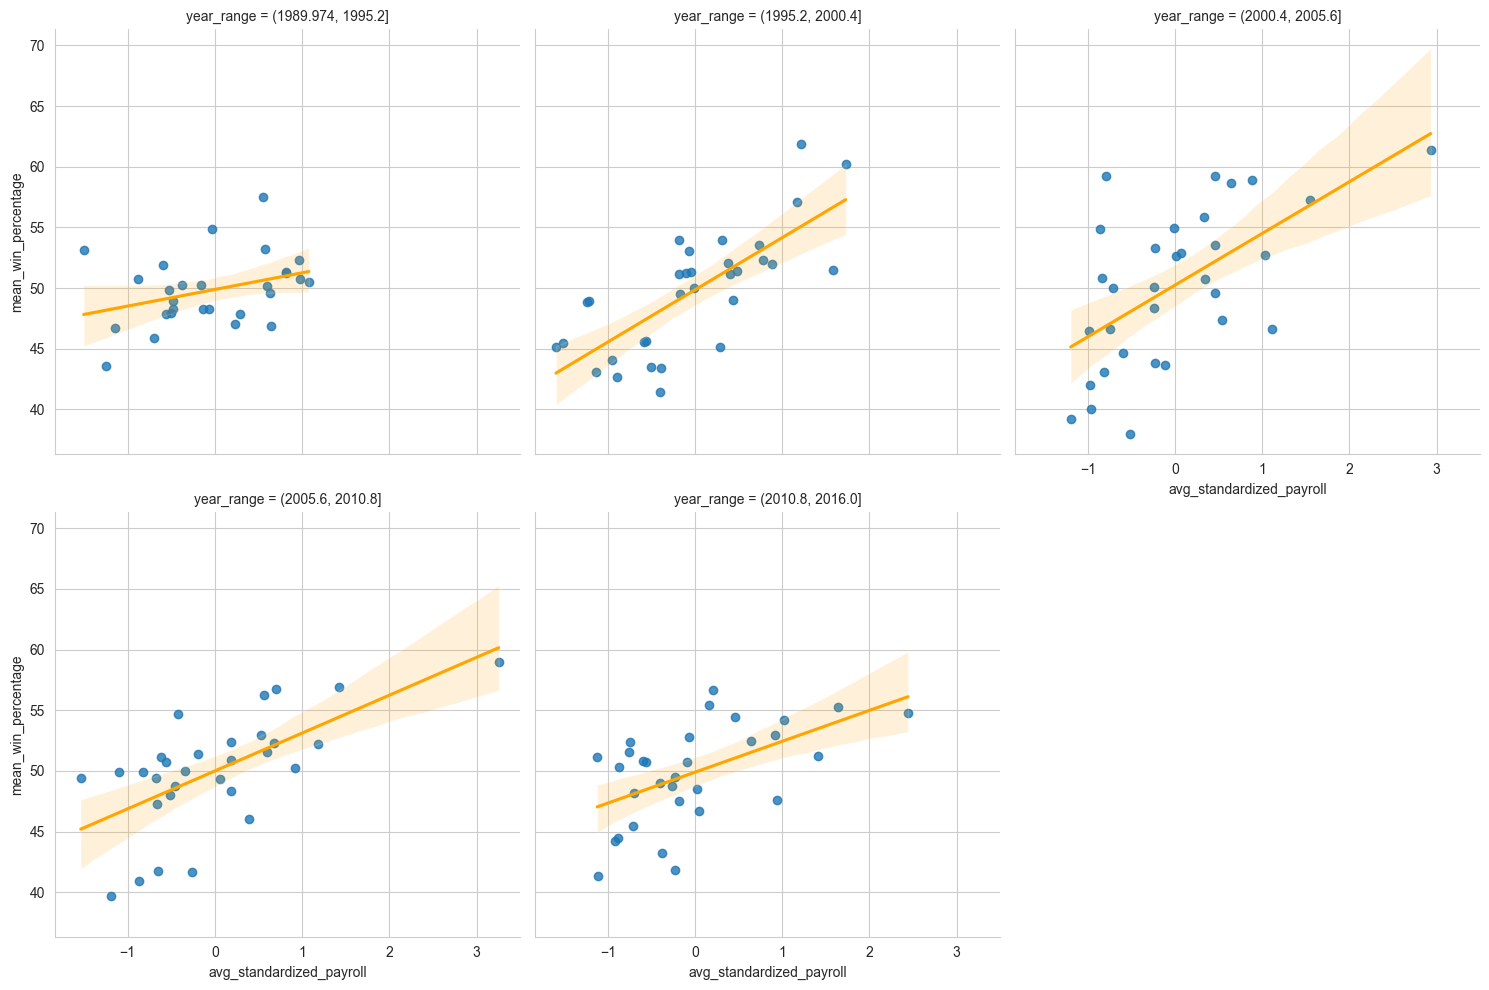

In [20]:
#Plotting after standardizing
sns.lmplot(data=stand_data, x="avg_standardized_payroll", y="mean_win_percentage",
           col="year_range", col_wrap=3, line_kws={'color': 'orange'})

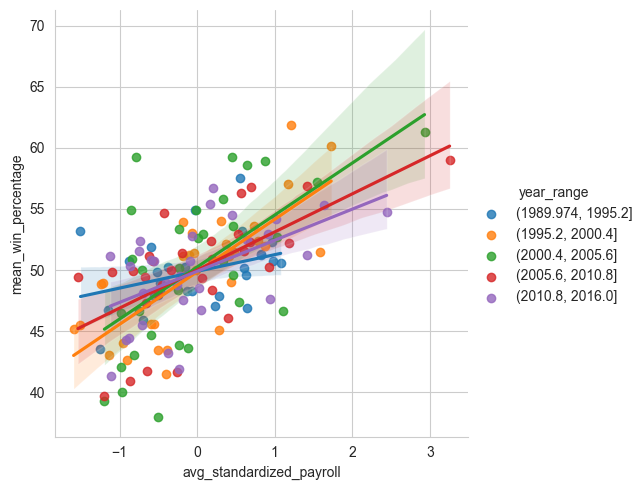

In [21]:
#Plotting all lines at once
sns.lmplot(stand_data, x='avg_standardized_payroll', y='mean_win_percentage', hue='year_range')

##Question 3


Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.


---
Centering the data around zero and dividing the standard deviation so that the resultant data has standard deviation 1 and mean 0. This procedure is called standardization or normalization and the result is called z-score.

Payroll is dependent on the year (The mean payroll increases per time). We have removed this time dependency on payroll.

We can observe that
1. NYA's standardized payroll deviated the most in most of the situations and has impressive win percentage.
2. OAK as usual has the the one of the best win percentage in the year range 2001 - 2005

In [22]:
#Plotting with coordinates
px.scatter(stand_data, x='avg_standardized_payroll', y='mean_win_percentage', color='teamID',
            facet_col='year_range', facet_col_wrap=3)

c:\UMD\Sem 1\MSML602 Principles in Data Science\.venv\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [23]:
#OAK data
oak_standardized_data = copy.deepcopy(stand_data[stand_data['teamID'] == 'OAK'])
px.scatter(oak_standardized_data, x='avg_standardized_payroll', y='mean_win_percentage',
            facet_col='year_range', facet_col_wrap=3)

c:\UMD\Sem 1\MSML602 Principles in Data Science\.venv\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##Problem 7

In [24]:
#Plotting the relation between the standardized payroll and win percentage
stand_payroll_win_data = payroll_win_data.groupby(by='yearID')[['win_percentage', 'standardized_payroll']].agg('mean')

In [25]:
stand_payroll_win_data

,win_percentage,standardized_payroll
yearID,,
1990,49.998525,2.305848e-16
1991,49.997193,-3.416071e-17
1992,50.000000,8.540177e-18
1993,50.000000,-1.586033e-16
1994,50.025744,-7.930164e-18
1995,49.995519,-3.251367e-16
1996,50.000959,3.033288e-16
1997,49.998494,2.339399e-16
1998,49.996319,1.332268e-16


In [26]:
px.scatter(stand_payroll_win_data, x='standardized_payroll', y='win_percentage',
           trendline='ols', title="Win percentage vs Standardized payroll per year",
           trendline_color_override='orange')

In [27]:
#Regression line coefficients
np.polyfit(stand_payroll_win_data['standardized_payroll'],
           stand_payroll_win_data['win_percentage'], deg=1)

array([2.59742543e+11, 4.99996259e+01])

In [28]:
px.scatter(data_frame=payroll_win_data, x='standardized_payroll', y='win_percentage',
           trendline='ols', title="Win percentage vs Standardized payroll", 
           trendline_color_override='orange')

In [29]:
np.polyfit(payroll_win_data['standardized_payroll'], payroll_win_data['win_percentage'], deg=1)

array([ 2.76046979, 49.99958537])

Applying the below equation for the team, we get
$$expected\_win\_pct_{ij} = 50 + 2.5 \times standardized\_payroll_{ij}$$

In [30]:
#Since expected win percentage is found
payroll_win_data['expected_win_pct'] = 50 + 2.5 * payroll_win_data['standardized_payroll']

##Problem 8
$$efficiency_{ij} = win\_pct_{ij} - expected\_win\_pct_{ij}$$

In [31]:
payroll_win_data['efficiency'] = payroll_win_data['win_percentage'] - payroll_win_data['expected_win_pct']
payroll_win_data

,total_payroll,W,L,total_games,win_percentage,yearID,teamID,year_range,index,mean,std,standardized_payroll,expected_win_pct,efficiency
0,14555501.0,65,97,162,40.123457,1990,ATL,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,-0.667275,48.331811,-8.208354
1,9680084.0,76,85,161,47.204969,1990,BAL,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,-1.959861,45.100348,2.104621
2,20558333.0,88,74,162,54.320988,1990,BOS,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,0.924213,52.310533,2.010454
3,21720000.0,80,82,162,49.382716,1990,CAL,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,1.232198,53.080495,-3.697779
4,9491500.0,94,68,162,58.024691,1990,CHA,"(1989.974, 1995.2]",0,1.707235e+07,3.771834e+06,-2.009859,44.975353,13.049338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,143053500.0,86,76,162,53.086420,2016,SLN,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,0.387050,50.967625,2.118794
784,57097310.0,68,94,162,41.975309,2016,TBA,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,-1.456238,46.359406,-4.384097
785,176038723.0,95,67,162,58.641975,2016,TEX,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,1.094402,52.736005,5.905970
786,138701700.0,89,73,162,54.938272,2016,TOR,"(2010.8, 2016.0]",26,1.250046e+08,4.663199e+07,0.293728,50.734320,4.203952


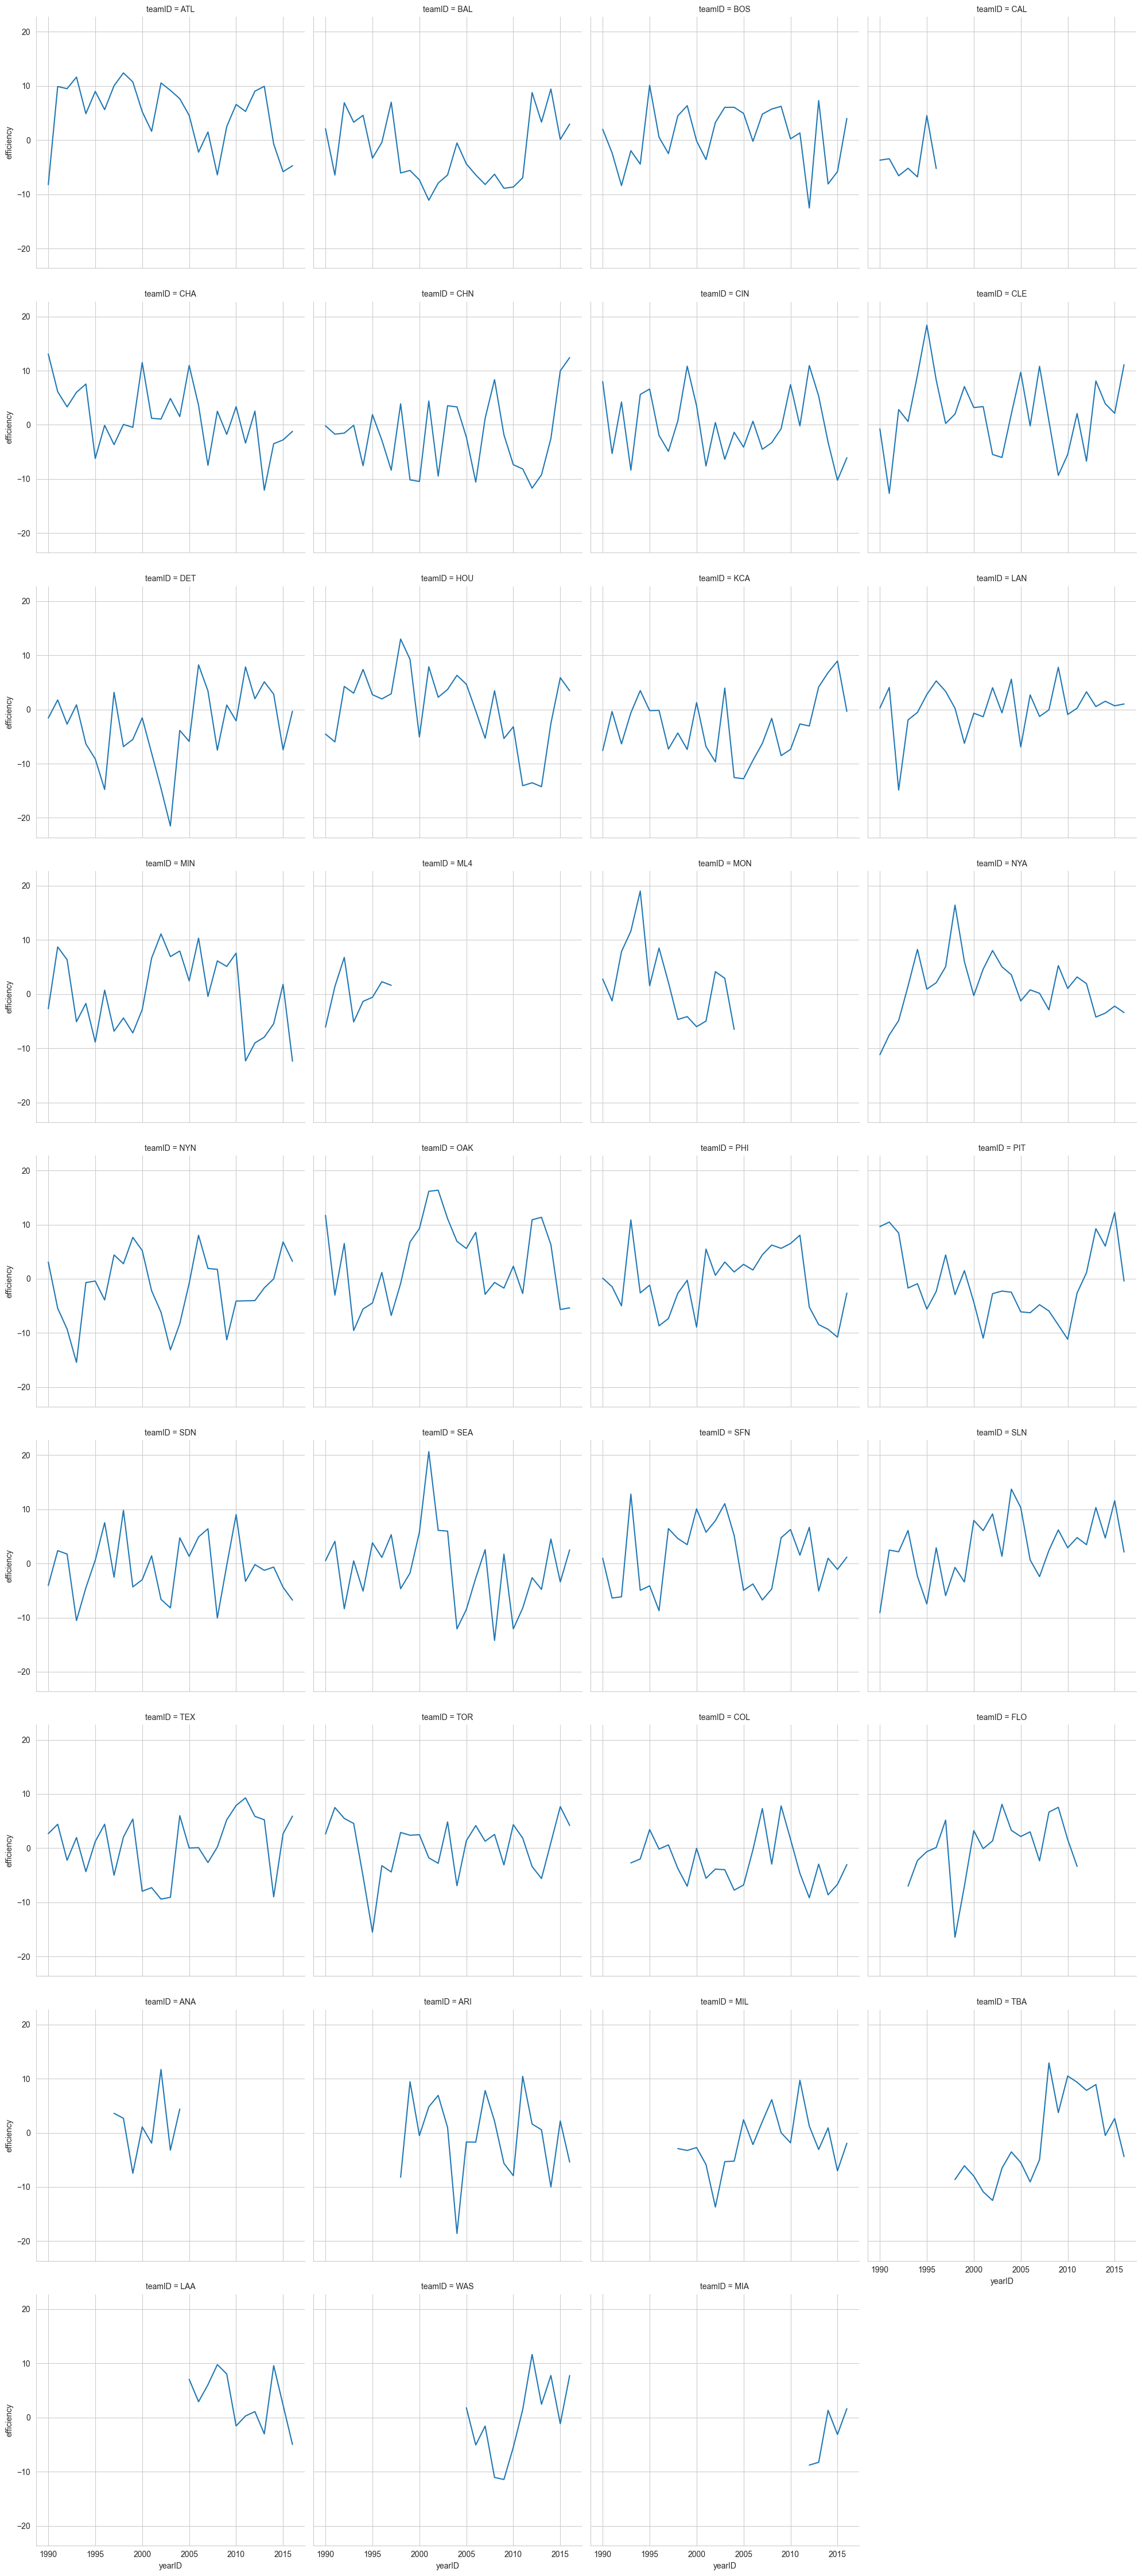

In [32]:
sns.relplot(data=payroll_win_data, x='yearID', y='efficiency', kind='line',
           col='teamID', col_wrap=4)

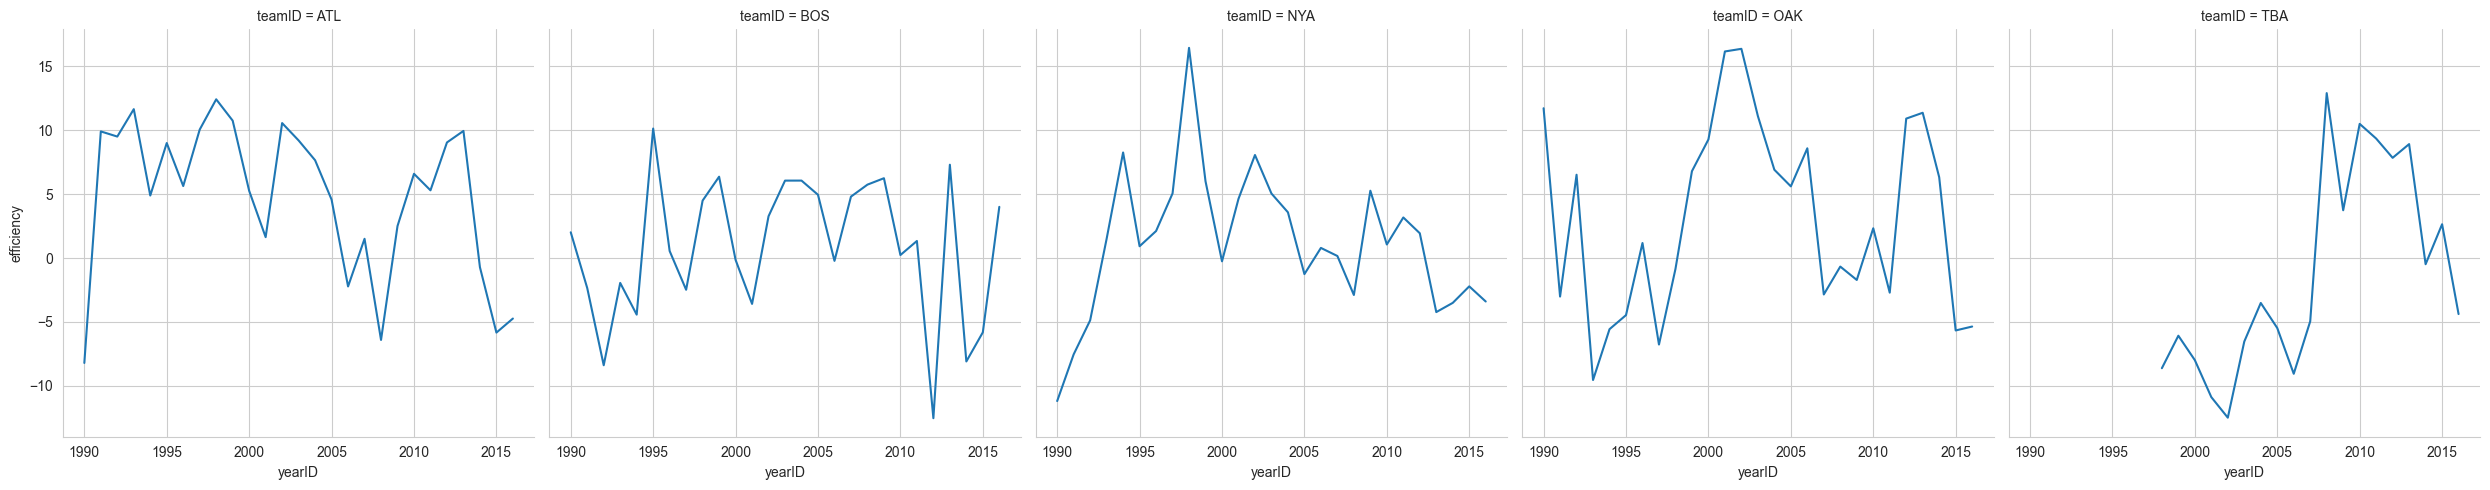

In [33]:
good_teams = payroll_win_data[payroll_win_data['teamID'].isin(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])]

sns.relplot(data=good_teams, x='yearID', y='efficiency', kind='line',
           col='teamID')

##Question 4

What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3?

---

We found in average, with an increase of `standardized payroll` by 1 unit, the win percentage to increase by 2.5%. Here efficiency determines the excess amount of win percentage when compared with average.

How good was Oakland's efficiency during the Moneyball period?

---
During the Moneyball period, OAK has the best efficiency, which is above 15% and no other good team is that efficient.